## Deep Learning Approaches for RF-based detection & classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from torchsummary import summary

### Load Features

In [2]:
feat_folder = '../Features/'
feat_name = 'SPEC'
seg_len = 20
n_per_seg = 1024
interferences = ['WIFI','CLEAN','BLUE','BOTH']
output_name = 'drones'
feat_format = 'IMG'

dataset = DroneDetectTorch(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
                                output_name, interferences)

# dataset = load_dronedetect_data(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
#                                 output_name, interferences)

Directory Name:  ../Features/IMG_SPEC_1024_20/


In [3]:
print('dataset size', len(dataset))
print('shape of each item', dataset.__getitem__(12)[0].shape)

dataset size 36778
shape of each item torch.Size([224, 224, 3])


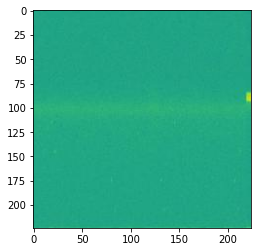

In [42]:
d = dataset.__getitem__(4)[0]
plt.imshow(d)
plt.show()

## VGG16 Features

In [45]:
vgg16 = models.vgg16()
# summary(vgg16, (3,224,224))

modules=list(vgg16.children())[:-1]
vggmodel=nn.Sequential(*modules)

for p in vggmodel.parameters():
    p.requires_grad = False

In [46]:
# test one input
d = dataset.__getitem__(0)
inarr = d[0]
inarr = torch.moveaxis(inarr, 2, 0)
# print(inarr.shape)
# postmove = inarr[0]
# print(premove==postmove) # confirm it is the same channel

# WHEN using single channel array format
# inputr = inarr.repeat(1,3,1,1)
# inputr = inputr.to(device)
out = vggmodel(inarr)

# reshape the output
out.flatten()

tensor([0.0000, 0.0196, 0.0182,  ..., 0.0562, 0.0534, 0.0152])

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vggmodel = vggmodel.to(device) #set model to device

Vgg_Feats = []
Vgg_y_num = [] # numerical values for y
for n in tqdm(range(len(dataset))):
    d = dataset.__getitem__(n)
    inarr = d[0]
#     inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
    inputr = torch.moveaxis(inarr, 2, 0) # move axis to have channels come first
    inputr = inputr.to(device)
    out = vggmodel(inputr)
    
    Vgg_Feats.append(out.cpu().numpy().flatten())
    Vgg_y_num.append(np.array(d[1]))

Vgg_Feats = np.array(Vgg_Feats)
Vgg_y_num = np.array(Vgg_y_num)

# flatten the middle dimension
Vgg_Feats = Vgg_Feats.reshape(Vgg_Feats.shape[0], Vgg_Feats.shape[-1])
# invert labels back to categorical
# vgg_y_cat = dataset.le.inverse_transform(vgg_y.astype(np.int64))
Vgg_y_cat = np.array([dataset.idx_to_class[i] for i in Vgg_y_num])

100%|███████████████████████████████████████████████████████████████████████████████████| 36778/36778 [02:07<00:00, 288.79it/s]


In [40]:
# Save VGG features
# vgg_save = {'feats': vgg_feats, 'y_cat':vgg_y_cat, 'y':vgg_y}
# file_name = 'transfer_learning_feats/VggFeats_'+str(seg_len)+'_'+str(n_per_seg)+'correct_psd_img'
# np.save(file_name, vgg_save)

## Resnet Features

In [74]:
## Transfer learning from Resnet50 & Apply Logistic Regression (Swinney paper)

# use pretrained resnet feature and just keep up to the last layer
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [75]:
# test resnet
# input = torch.randn(1,1,30,300)
d = dataset.__getitem__(0)
inarr = d[0]
resnet50(inarr).shape

In [76]:
ResNet_Feats = []
y_num = []
for n in range(len(dataset)):
    d = dataset.__getitem__(n)
    inarr = d[0]
    inputr = torch.moveaxis(inarr, 2, 0) # move axis to have channels come first
    inputr = inputr.to(device)
    
    out = resnet50(inputr)
    ResNet_Feats.append(np.array(out))
    y_num.append(np.array(d[1]))

ResNet_Feats = np.array(ResNet_Feats)
y_num = np.array(y_num)

# flatten the middle dimension
ResNet_Feats = resnet_feats.reshape(ResNet_Feats.shape[0], ResNet_Feats.shape[-1])
# invert labels back to categorical
# y_cat = dataset.le.inverse_transform(y_num.astype(np.int64))
resnet_y_cat = np.array([dataset.idx_to_class[i] for i in ResNet_Feats])

### Run Logistic Regression

In [48]:
Xs_feat = Vgg_Feats # which features to use for logit reg
y_cat = Vgg_y_cat
print('Shape of Input Features: (n sample x n feats):', Xs_feat.shape)

Shape of Input Features: (n sample x n feats): (36778, 25088)


In [ ]:
# split data into K-fold
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(10,x),range(-2,2,1)))
print('Cs:', Cs)

best_params_ls = []
acc_ls = []
f1_ls = []
runt_ls = []

parameters = {'C':Cs}

for train_ix, test_ix in tqdm(cv.split(Xs_feat)):
    
    # find the optimal hypber parameters
    lr = LogisticRegression(solver='saga')
#     clf = GridSearchCV(lr, parameters, n_jobs=1) # gridsearch cv
    clf = LogisticRegression(C =1.0, max_iter=1000, class_weight = 'balanced',n_jobs=1) # fixed parameter
    
    scaler = preprocessing.StandardScaler().fit(Xs_feat[train_ix])
    X_train_scale = scaler.transform(Xs_feat[train_ix])
    
    clf.fit(X_train_scale, y_cat[train_ix])
    
#     print(clf.best_params_)
#     best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    X_test_scale = scaler.transform(Xs_feat[test_ix])
    y_pred, runtimes = atomic_benchmark_estimator(clf, X_test_scale, output_type= '<U3', 
                                                  verbose=False)
    runt_ls.append(np.mean(runtimes))
    
    acc = accuracy_score(y_cat[test_ix], y_pred)
    f1 = f1_score(y_cat[test_ix], y_pred, average='weighted')
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    acc_ls.append(acc)
    f1_ls.append(f1)
    
out_msg = 'Net+LR: average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
print(out_msg)

Cs: [0.01, 0.1, 1, 10]


0it [00:00, ?it/s]

In [ ]:
y_cat

## Run kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
## Fixed parameter kNN
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=10, shuffle=True)

# Ns=list(range(2,100,20))
# Ns = [100]
parameters = {'n_neighbors':Ns}
print('list of neighbours:', Ns)

Xs_arr = Vgg_Feats
y_arr = Vgg_y_cat

best_params_ls = []
score_ls = []
f1_ls = []

for train_ix, test_ix in cv.split(Xs_arr):
    # scale data
    scaler = preprocessing.StandardScaler().fit(Xs_arr[train_ix])
    X_train_scale = scaler.transform(Xs_arr[train_ix])
    
    # find the optimal hypber parameters
    clf = KNeighborsClassifier(n_neighbors=5)
#     clf = GridSearchCV(neigh, parameters, n_jobs=1)
    clf.fit(X_train_scale, y_arr[train_ix])
#     print(clf.best_parameters)
    
    # predict on the test data
    X_test_scale = scaler.transform(Xs_arr[test_ix])
#     y_pred = clf.predict(X_test_scale)
    y_pred, runtimes = atomic_benchmark_estimator(clf, X_test_scale, output_type= '<U3', 
                                                  verbose=False)
    acc = accuracy_score(y_arr[test_ix], y_pred)
    f1 = f1_score(y_arr[test_ix], y_pred, average='weighted')
    f1_ls.append(f1)
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    score_ls.append(acc)
    
print('VGG feats+kNN K-fold average test score:', np.mean(score_ls))
print('VGG feats+kNN K-fold average test F1:', np.mean(f1_ls))

list of neighbours: [100]


## Fully Connected Layer

In [29]:
class VGGFC(nn.Module):
    def __init__(self, num_classes):
        super(VGGFC,self).__init__()
        self.num_classes = num_classes
        self.vggfull = models.vgg16(pretrained=True)
        modules=list(self.vggfull.children())[:-1] # remove the fully connected layer & adaptive averaging
        self.vggfeats=nn.Sequential(*modules)
        
        for param in self.vggfeats.parameters():
            param.requires_grad_(False)
        
        self._fc = nn.Linear(25088, num_classes)
    def forward(self, x):
        if len(x.shape)==4:
            x = torch.moveaxis(x,-1, 1)
        else:
            x = torch.moveaxis(x, -1, 0)
        x = self.vggfeats(x)
        x = x.reshape(x.shape[0],25088)
        x = self._fc(x)
        
        return x

### Kfold CV

In [30]:
from nn_functions import runkfoldcv

In [35]:
a=1

In [40]:
# Configuration options
k_folds = 5

batch_size = 128 # 128
num_classes = 7
learning_rate = 0.01
num_epochs = 25 # 0
momentum = 0.95
l2reg = 1e-4

Model = VGGFC(num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
runkfoldcv(Model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
    Loss after mini-batch    50: 1.35745
    Loss after mini-batch   100: 0.97597
    Loss after mini-batch   150: 0.87031
    Loss after mini-batch   200: 0.81131
Starting epoch 2
    Loss after mini-batch    50: 0.71293
    Loss after mini-batch   100: 0.67999
    Loss after mini-batch   150: 0.65161
    Loss after mini-batch   200: 0.63998
Starting epoch 3
    Loss after mini-batch    50: 0.59697
    Loss after mini-batch   100: 0.58523
    Loss after mini-batch   150: 0.56022
    Loss after mini-batch   200: 0.57325
Starting epoch 4
    Loss after mini-batch    50: 0.52805
    Loss after mini-batch   100: 0.53279
    Loss after mini-batch   150: 0.51023
    Loss after mini-batch   200: 0.52119
Starting epoch 5
    Loss after mini-batch    50: 0.48830
    Loss after mini-batch   100: 0.49656
    Loss after mini-batch   150: 0.47366
    Loss after mini-batch   200: 0.48392
Starting epoch 6
    L

    Loss after mini-batch   200: 0.21454
Starting epoch 20
    Loss after mini-batch    50: 0.20795
    Loss after mini-batch   100: 0.21217
    Loss after mini-batch   150: 0.20373
    Loss after mini-batch   200: 0.20223
Starting epoch 21
    Loss after mini-batch    50: 0.19951
    Loss after mini-batch   100: 0.20002
    Loss after mini-batch   150: 0.20935
    Loss after mini-batch   200: 0.20462
Starting epoch 22
    Loss after mini-batch    50: 0.20382
    Loss after mini-batch   100: 0.19489
    Loss after mini-batch   150: 0.20153
    Loss after mini-batch   200: 0.20080
Starting epoch 23
    Loss after mini-batch    50: 0.19604
    Loss after mini-batch   100: 0.19991
    Loss after mini-batch   150: 0.20048
    Loss after mini-batch   200: 0.19746
Starting epoch 24
    Loss after mini-batch    50: 0.19027
    Loss after mini-batch   100: 0.19358
    Loss after mini-batch   150: 0.20289
    Loss after mini-batch   200: 0.19654
Starting epoch 25
    Loss after mini-batch    50

Starting epoch 13
    Loss after mini-batch    50: 0.14752
    Loss after mini-batch   100: 0.14779
    Loss after mini-batch   150: 0.13991
    Loss after mini-batch   200: 0.14463
Starting epoch 14
    Loss after mini-batch    50: 0.14440
    Loss after mini-batch   100: 0.15256
    Loss after mini-batch   150: 0.14032
    Loss after mini-batch   200: 0.14323
Starting epoch 15
    Loss after mini-batch    50: 0.14660
    Loss after mini-batch   100: 0.13953
    Loss after mini-batch   150: 0.14616
    Loss after mini-batch   200: 0.14201
Starting epoch 16
    Loss after mini-batch    50: 0.14499
    Loss after mini-batch   100: 0.13876
    Loss after mini-batch   150: 0.14268
    Loss after mini-batch   200: 0.13908
Starting epoch 17
    Loss after mini-batch    50: 0.14270
    Loss after mini-batch   100: 0.13898
    Loss after mini-batch   150: 0.13914
    Loss after mini-batch   200: 0.13885
Starting epoch 18
    Loss after mini-batch    50: 0.13862
    Loss after mini-batch   100

(91.36728943736972, 0.913539936546195, 0.005702200392324619)

In [11]:
# Reload modules for testing
# import importlib
# import nn_functions
# importlib.reload(nn_functions)
# from nn_functions import *

 ### resnet & a fully connected layer

In [ ]:
# # Define network
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
# model.classifier = nn.Linear(model.classifier[0].in_features, num_classes)
# print(model)

In [105]:
class ResnetFC(nn.Module):
    def __init__(self, num_classes):
        super(ResnetFC,self).__init__()
        self.num_classes = num_classes
        self.resnetfull = models.resnet50(pretrained=True)
        modules=list(self.resnetfull.children())[:-2] # remove the fully connected layer & adaptive averaging
        self.resnetfeats=nn.Sequential(*modules)
        
        for param in self.resnetfeats.parameters():
            self.resnetfeats.requires_grad_(False)
        
        self._fc = nn.Linear(1505280, num_classes)
    def forward(self, x):
#         batch_size ,_,_ =x.shape
        
        # replicate the image to have 3 channels
        x = x.repeat(1,3,1,1)
        print(x.shape)
        x = self.resnetfeats(x)
        x = x.flatten()
        print(x.shape)
        x = self._fc(x)
        
        return x

In [106]:
fctest = ResnetFC(7)

In [107]:
test_input = dataset.__getitem__(10)[0]
print(test_input.shape)

torch.Size([129, 4687])


In [110]:
# Test an input
test_input = dataset.__getitem__(10)[0]
# test_input = torch.rand(1, 129, 4687)

test_input = test_input.unsqueeze(axis=0)
print(test_input.shape)
fctest.forward(test_input)

torch.Size([1, 129, 4687])
torch.Size([1, 3, 129, 4687])
torch.Size([1505280])


tensor([ 0.3626,  0.2002,  0.4983, -0.0624, -0.0184, -0.0807,  0.5689],
       grad_fn=<AddBackward0>)

In [82]:
fctest.resnetfeats.cuda()
FULLRES = models.resnet50(pretrained=True)
FULLRES = FULLRES.cuda()
summary(FULLRES, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [89]:
print(list(FULLRES.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr